# Purpose of the notebook

We run a switchback test because we cannot run treatment and control at the same time at a certain location. We can, however, run treatment and control at the same time at different locations that are very similar.

We explore the idea if we choose a counterpart city that is as much correlated as possible to the first city and where the setup of the counterpart city always mirrors the setup of city 1. If city 1 is on A at a certain time, the counterpart city will be on B.

The idea is that because of the existing correlations between the cities, the fluctuations cancel each other out.

# Imports

In [1]:
from google.cloud import bigquery
from google.cloud import bigquery_storage
import seaborn as sns
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from statsmodels.stats.weightstats import ttest_ind
from statsmodels.stats.power import tt_ind_solve_power
from tqdm import tqdm
import statsmodels.formula.api as smf
import pandas as pd
tqdm.pandas()

/Users/o.weisse/switchback_test_dag/venv/lib/python3.9/site-packages/requests/__init__.py:109: RequestsDependencyWarning: urllib3 (1.26.11) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn(


# Download Data

In [2]:
def download_data(entity_ids, start_date, end_date):
    query = f"""
    SELECT
    entity_id,
    rider.city_id,
    created_date,
    created_at,
    orders.rider.timings.actual_delivery_time/60 delivery_time,
    orders.rider.timings.order_delay/60 order_delay,
    orders.rider.timings.bag_time/60 bag_time,
    --ARRAY(SELECT d.dropoff_distance_manhattan FROM UNNEST(orders.rider.deliveries) AS d)[OFFSET(0)] distance,
    FROM `fulfillment-dwh-production.cl.orders_v2`orders
    WHERE created_date BETWEEN "{start_date}" AND "{end_date}"
    AND entity_id in {tuple(entity_ids)}
    """
    client = bigquery.Client(project = 'logistics-data-staging-flat')
    bq_storage_client = bigquery_storage.BigQueryReadClient() # Instantiate a BQ storage client
    data = client.query(query).result()\
    .to_dataframe(bqstorage_client = bq_storage_client, progress_bar_type = 'tqdm_notebook')
    return data

In [3]:
entity_ids = ['FP_TW', "PY_CL", "PY_BO", "PY_CR", "PH_MY"]
start_date = "2023-05-01"
end_date = "2023-05-14"
data = download_data(entity_ids, start_date, end_date)

Downloading:   0%|          | 0/9158787 [00:00<?, ?rows/s]

In [4]:
KPI = "delivery_time"

In [5]:
# filter
data = data[data['delivery_time']<120]
data = data[data['delivery_time']>0]
data = data[data[KPI].notnull()]

<AxesSubplot:xlabel='delivery_time', ylabel='Density'>

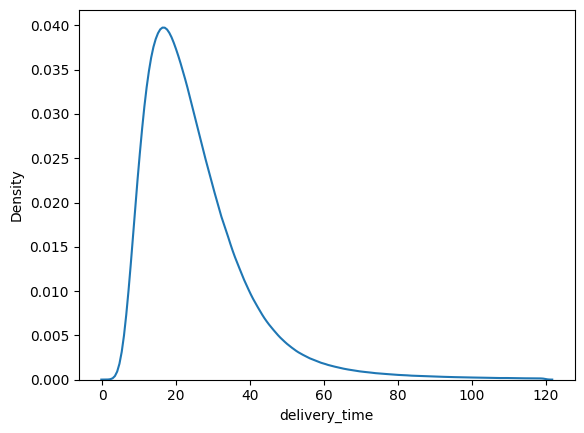

In [6]:
sns.kdeplot(data[KPI])

In [7]:
data[KPI].mean()

25.326309211409765

# Confidence Intervals per window size

In [8]:
def randomize_time_unit_assignment(data):
    """Creates a new columns called 'group'. Assigns each time unit randomly to either group A or B."""
    time_unit_group_dict = {i: np.random.choice(['A', 'B']) for i in data.time_unit.unique()}
    data['group'] = data['time_unit'].map(time_unit_group_dict)

In [9]:
def CRSE_CI(data, KPI):
    """Calculates the CI for cluster robust standard error method."""
    data["group_binary"] = data['group'].map({"A":0, "B": 1})
    model = smf.ols(formula=f'{KPI} ~ group_binary', data=data)
    results = model.fit(cov_type="cluster", cov_kwds={'groups': data['time_unit']})
    std_err = results.bse["group_binary"]
    mean_diff = results.params["group_binary"]
    return std_err, mean_diff

# Find correlated cities

In [10]:
# assign to group with hourly switchback interval
data['time_unit'] = data['created_at'].dt.floor("1H")
randomize_time_unit_assignment(data)

In [11]:
data['entity_city_id'] = data['entity_id']+data['city_id'].astype(str)

In [12]:
time_unit_means = data.groupby(['time_unit', 'entity_city_id'])[KPI].mean().unstack()

In [13]:
time_unit_means.corr()['FP_TW1'].sort_values().iloc[-2:-1]

entity_city_id
FP_TW202    0.753595
Name: FP_TW1, dtype: float64

Text(0.5, 1.0, 'DT means per time unit')

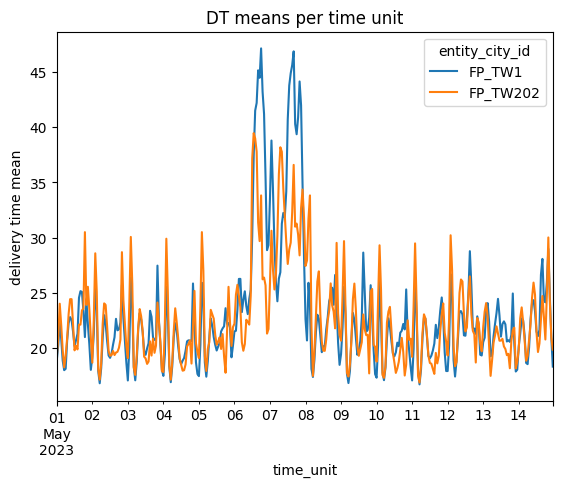

In [14]:
time_unit_means[['FP_TW1', "FP_TW202"]].plot()
plt.ylabel('delivery time mean')
plt.title("DT means per time unit")

We can see that those two cities are very much correlated and that differences might cancel each other out. We will now perform a FPR and sensitivity analysis.

### FPR analysis for counterpart method

In [15]:
def randomize_time_unit_assignment_counterpart(data, counterpart_column, counterpart1, counterpart2):
    """Creates a new column called 'group'. Assigns each time unit randomly to either group A or B. It does so
    for two counterparts that are similar like the city_id. If one city is assigned to A, the other city is assigned
    to be B at the same time."""
    time_unit_group_dict = {i: np.random.choice(['A', 'B']) for i in data.time_unit.unique()}
    time_unit_group_dict_reversed = {i:"A" if (time_unit_group_dict[i] == "B") else "B" for i in time_unit_group_dict}
    data['original_group'] = data['time_unit'].map(time_unit_group_dict)
    data['reversed_group'] = data['time_unit'].map(time_unit_group_dict_reversed)
    data['group'] = np.where(data[counterpart_column]!=counterpart1, data['original_group'], data['reversed_group'])

In [16]:
def randomize_time_unit_and_city_assignment(data):
    """Creates a new columns called 'group'. Assigns each time unit randomly to either group A or B."""
    data['group'] = np.random.choice(['A', 'B'], size=len(data))
    data['group'] = data.groupby(['time_unit', 'entity_city_id'])['group'].transform('first')

In [17]:
def CRSE_significance(data, KPI_A, KPI_B, threshold=0):
    """Uses the cluster robust standard error method to check for significance."""
    data["group_binary"] = data['group'].map({"A":0, "B": 1})
    data['KPI'] = np.where(data['group']=="A", data[KPI_A], data[KPI_B])
    model = smf.ols(formula=f'KPI ~ group_binary', data=data)
    p = model.fit(cov_type="cluster", cov_kwds={'groups': data['time_unit']}).pvalues["group_binary"]
    if p < 0.05:
        return True

In [18]:
def FPR(data, KPI, randomization_function, counterpart_column, counterpart1, counterpart2, n_iterations=1000, 
        threshold = 0):
    """Calculates the false positive rate for the CRSE for different randomization methods."""
    effect_found = 0
    for i in tqdm(range(n_iterations)):
        if randomization_function != randomize_time_unit_assignment_counterpart:
            randomization_function(data)
        else:
            randomization_function(data, counterpart_column, counterpart1, counterpart2)
        if CRSE_significance(data, KPI, KPI, threshold):
            effect_found += 1
    return effect_found/n_iterations

In [19]:
class percentage_metric:
    """Percentage metric is a single float value and has an uncertainty according to the standard error of
    the mean of a bernoulli distributed variable."""
    def __init__(self, value, N):
        self.value = value
        self.unc = 2*np.sqrt(value*(1-value)/N)
        
    def __repr__(self):
        return str(self.value)+'+-'+str(self.unc)

In [20]:
data_two_cities = data[data['entity_city_id'].isin(["FP_TW1", "FP_TW202"])].sample(frac=0.01)

In [57]:
result = FPR(data_two_cities, "delivery_time", randomize_time_unit_assignment, "entity_city_id", "FP_TW1", "FP_TW202", 1000)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:23<00:00,  6.99it/s]


In [59]:
percentage_metric(result, 1000)

0.052+-0.014042222046385677

In [60]:
result = FPR(data_two_cities, "delivery_time", randomize_time_unit_assignment_counterpart, 
    "entity_city_id", "FP_TW1", "FP_TW202", 1000)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:28<00:00,  6.74it/s]


In [61]:
percentage_metric(result, 1000)

0.045+-0.013111064030047295

In [62]:
result = FPR(data_two_cities, "delivery_time", randomize_time_unit_and_city_assignment, 
    "entity_city_id", "FP_TW1", "FP_TW202", 1000)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:26<00:00,  6.85it/s]


In [63]:
percentage_metric(result, 1000)

0.053+-0.01416912135596276

### power analysis for counterpart method

In [26]:
def power(data, KPI, effect_size, randomization_function, counterpart_column, counterpart1, counterpart2, n_iterations=1000, 
        threshold = 0):
    """Calculates the false positive rate for the CRSE for different randomization methods."""
    effect_found = 0
    for i in tqdm(range(n_iterations)):
        if randomization_function != randomize_time_unit_assignment_counterpart:
            randomization_function(data)
        else:
            randomization_function(data, counterpart_column, counterpart1, counterpart2)
        data[KPI+"_simulated"] = data[KPI]+effect_size
        if CRSE_significance(data, KPI, KPI+"_simulated", threshold):
            effect_found += 1
    return effect_found/n_iterations

In [27]:
power(data_two_cities, "delivery_time", 1, randomize_time_unit_assignment, "entity_city_id", "FP_TW1", "FP_TW202", 1000)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:15<00:00,  7.37it/s]


0.402

In [28]:
power(data_two_cities, "delivery_time", 1, randomize_time_unit_assignment_counterpart, "entity_city_id", "FP_TW1", "FP_TW202", 1000)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:19<00:00,  7.18it/s]


0.665

In [29]:
power(data_two_cities, "delivery_time", 1,randomize_time_unit_and_city_assignment, "entity_city_id", "FP_TW1", "FP_TW202", 1000)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:13<00:00,  7.50it/s]


0.5

### Difference distribution for counterpart method

In [30]:
def get_difference_distribution(data, randomization_function, counterpart_column, counterpart1, counterpart2,
                                n_iterations=100):
    """Get the difference distribution between the means of A and B by bootstrapping."""
    measured_effects = []
    for i in tqdm(range(100)):
        if randomization_function == randomize_time_unit_assignment:
            randomization_function(data)
        else:
            randomization_function(data, counterpart_column, counterpart1, counterpart2)
        measured_effect = data[data['group']=='A'][KPI].mean()-data[data['group']=='B'][KPI].mean()
        measured_effects.append(measured_effect)
    return measured_effects

In [31]:
diff_distribution = get_difference_distribution(
    data_two_cities,randomize_time_unit_assignment, "entity_city_id", "FP_TW1", "FP_TW202", 100)

diff_distribution_counterpart = get_difference_distribution(
    data_two_cities,randomize_time_unit_assignment_counterpart, "entity_city_id", "FP_TW1", "FP_TW202", 100)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 55.46it/s]


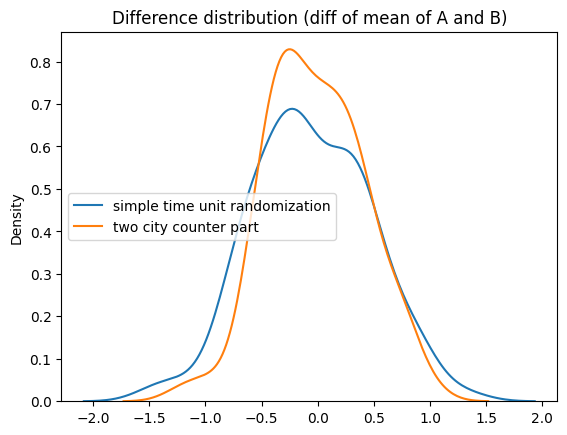

In [32]:
sns.kdeplot(diff_distribution)
sns.kdeplot(diff_distribution_counterpart)
plt.title('Difference distribution (diff of mean of A and B)')
plt.legend(["simple time unit randomization", "two city counter part"])

We can see that the difference distribution (under the null hypothesis) is much sharper for the counterpart method and that this allows us to have better sensitivity.

In [33]:
np.std(diff_distribution)

0.5195795128362459

In [34]:
np.std(diff_distribution_counterpart)

0.4275291412036255

# Confidence interval for different randomization methods

We will compare the confidence intervals for randomizing only on time unit, randomizing on time and city unit and the counterpart method.

In [35]:
randomize_time_unit_assignment(data_two_cities)
CI_time_unit, _ = CRSE_CI(data_two_cities, KPI)

In [36]:
randomize_time_unit_assignment_counterpart(data_two_cities, "entity_city_id", "FP_TW1", "FP_TW202")
CI_counterpart, _ = CRSE_CI(data_two_cities, KPI)

In [37]:
randomize_time_unit_and_city_assignment(data_two_cities)
CI_time_city_unit, _ = CRSE_CI(data_two_cities, KPI)

Text(0.5, 1.0, 'Confidence interval for effect on delivery time for different randomization methods')

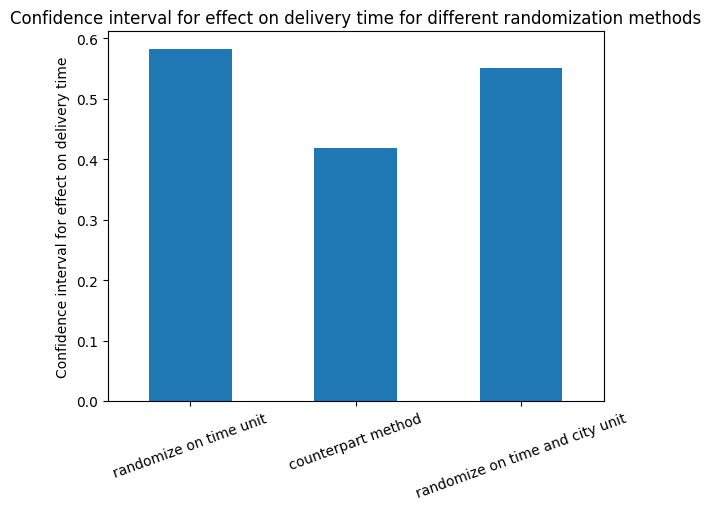

In [38]:
pd.Series([CI_time_unit, CI_counterpart, CI_time_city_unit], 
          index=["randomize on time unit", "counterpart method", 'randomize on time and city unit']).plot.bar(rot=20)
plt.ylabel("Confidence interval for effect on delivery time")
plt.title("Confidence interval for effect on delivery time for different randomization methods")

# Finding the best city mix

Ideally, before we run a test, we should find the best location for a switchback test. This will be a location where we have fluctuations that are as small as possible. This can be done either by checking the confidence interval directly or by agrregating on time unit and checking the standard deviation.

Once, we have found the best city, we might be able to find a counterpart city that decreases the CI or the standard deviation.

In [39]:
data_TW = data[data['entity_id']=='FP_TW']
time_unit_means = data_TW.groupby(['time_unit', 'entity_city_id'])[KPI].mean().unstack()
counts = data_TW.groupby(['entity_city_id'])[KPI].count()
weights = (counts/counts.sum()).to_dict()

In [40]:
time_unit_means.std().sort_values()

entity_city_id
FP_TW208    2.514720
FP_TW210    2.760132
FP_TW2      3.245528
FP_TW209    3.285696
FP_TW204    3.412780
FP_TW206    3.719981
FP_TW212    4.207800
FP_TW201    4.292090
FP_TW202    4.338548
FP_TW205    4.680441
FP_TW3      4.701851
FP_TW203    4.895723
FP_TW1      5.769284
FP_TW213    6.059793
FP_TW211    8.390446
dtype: float64

The best city for a test would be FP_TW208. Can we find a good counterpart city here?

In [41]:
for counterpart_city in time_unit_means.columns:
    print(counterpart_city)
    print((time_unit_means['FP_TW208']-time_unit_means[counterpart_city]).std())

FP_TW1
5.31197815281748
FP_TW2
2.898257347177412
FP_TW201
3.9402304941782686
FP_TW202
3.640622637668653
FP_TW203
4.623992223023695
FP_TW204
2.9334809956028276
FP_TW205
3.6896658212307485
FP_TW206
3.352341495672654
FP_TW208
0.0
FP_TW209
3.044718190112144
FP_TW210
2.523393639128211
FP_TW211
7.784325090525944
FP_TW212
4.343420394652904
FP_TW213
6.024696597991344
FP_TW3
4.3668571898587105


In this case FP_TW208 alone without counterpart is the best. But in other cases, we could add or substract other cities to the mix.

# Conclusion

The conclusion is that randomizing on city level additionally to the time level might improve the sensitivity slightly. The counterpart method performs even better than this.

One open question for the counterpart method is how to deal with more than one variant. In the worst case, this method might only be an effictive measure to improve sensitivity for two variants.